### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] Eye dataset 클래스

In [3]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
import torch

class NewEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)

        return left_img, right_img, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)

### [4] 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [5]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = NewEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] 모델 정의

In [6]:
import torch
import torch.nn as nn
import timm

class CrossAttentionBothEyeClassifier(nn.Module):
    def __init__(self, dropout_p=0.3, embed_dim=1280, num_heads=8):
        super(CrossAttentionBothEyeClassifier, self).__init__()

        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)

        # 양방향 Cross-Attention 정의
        self.cross_attn_L2R = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.cross_attn_R2L = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

        self.dropout = nn.Dropout(dropout_p)

        # 분류기: concat된 두 attention 결과 (1280 * 2)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

    def forward(self, left_img, right_img):
        # (B, 1280)
        left_feat = self.backbone(left_img)
        right_feat = self.backbone(right_img)

        # (B, 1, 1280) for attention input
        left_feat = left_feat.unsqueeze(1)
        right_feat = right_feat.unsqueeze(1)

        # 양방향 Cross-Attention
        # Left → Right
        attn_L2R, _ = self.cross_attn_L2R(query=left_feat, key=right_feat, value=right_feat)
        # Right → Left
        attn_R2L, _ = self.cross_attn_R2L(query=right_feat, key=left_feat, value=left_feat)

        # concat → (B, 1280*2)
        combined = torch.cat([attn_L2R.squeeze(1), attn_R2L.squeeze(1)], dim=1)
        combined = self.dropout(combined)

        return self.classifier(combined)


### [7] FocalLoss 클래스 정의

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # scalar or list (optional)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # [B]
        pt = torch.exp(-ce_loss)  # [B]
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # [B]

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프

In [8]:
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수
criterion_cls = FocalLoss()

# 모델 초기화 (양방향 크로스어텐션 모델)
model = CrossAttentionBothEyeClassifier(dropout_p=0.3).to(device)

# 옵티마이저 및 스케줄러
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 학습 설정
epochs = 20
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for left_imgs, right_imgs, labels in train_loader:
        left_imgs, right_imgs, labels = left_imgs.to(device), right_imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(left_imgs, right_imgs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left_imgs, right_imgs, labels in val_loader:
            left_imgs, right_imgs, labels = left_imgs.to(device), right_imgs.to(device), labels.to(device)

            outputs = model(left_imgs, right_imgs)
            loss = criterion_cls(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    # Best 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_crossattention_both_model.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Best model updated at epoch 1 (Val Loss: 0.1745)
Epoch 1/20 | Train Loss: 0.1598 | Val Loss: 0.1745 | Val Acc: 0.5600 | LR: 0.001000
Epoch 2/20 | Train Loss: 0.1500 | Val Loss: 0.2650 | Val Acc: 0.5250 | LR: 0.001000
Epoch 3/20 | Train Loss: 0.1485 | Val Loss: 0.2194 | Val Acc: 0.5200 | LR: 0.001000
Epoch 4/20 | Train Loss: 0.1421 | Val Loss: 0.2107 | Val Acc: 0.5000 | LR: 0.001000
Epoch 5/20 | Train Loss: 0.1506 | Val Loss: 0.1935 | Val Acc: 0.5000 | LR: 0.001000
Epoch 6/20 | Train Loss: 0.1516 | Val Loss: 0.1957 | Val Acc: 0.5000 | LR: 0.001000
Epoch 7/20 | Train Loss: 0.1485 | Val Loss: 0.2024 | Val Acc: 0.5000 | LR: 0.001000
Epoch 8/20 | Train Loss: 0.1482 | Val Loss: 0.2040 | Val Acc: 0.5000 | LR: 0.001000
Epoch 9/20 | Train Loss: 0.1483 | Val Loss: 0.2054 | Val Acc: 0.5000 | LR: 0.001000
Epoch 10/20 | Train Loss: 0.1482 | Val Loss: 0.2057 | Val Acc: 0.5000 | LR: 0.001000
Epoch 11/20 | Train Loss: 0.1482 | Val Loss: 0.2051 | Val Acc: 0.5000 | LR: 0.001000
Epoch 12/20 | Train Loss:

### [9] 손실 json 파일 저장

In [9]:
import json

# 저장할 경로
save_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_crossattention_both_model.json'

# 저장할 손실 딕셔너리
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}

# JSON 저장
with open(save_path, 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_crossattention_both_model.json 저장 완료!")


loss_history_crossattention_both_model.json 저장 완료!


### [10] loss 그래프

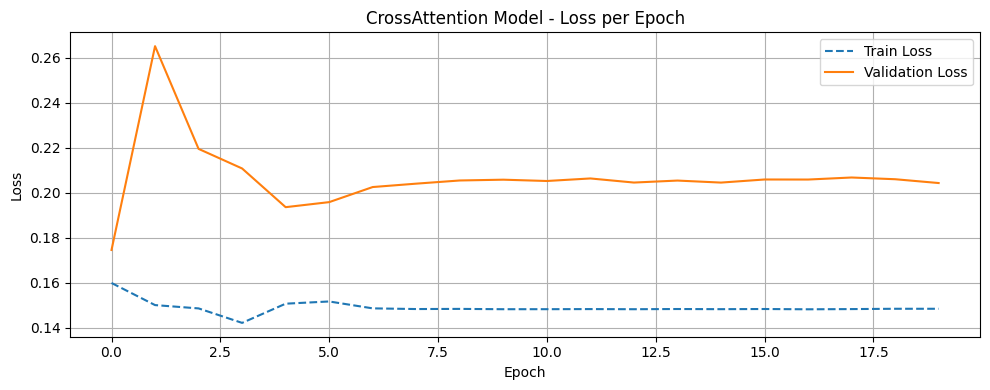

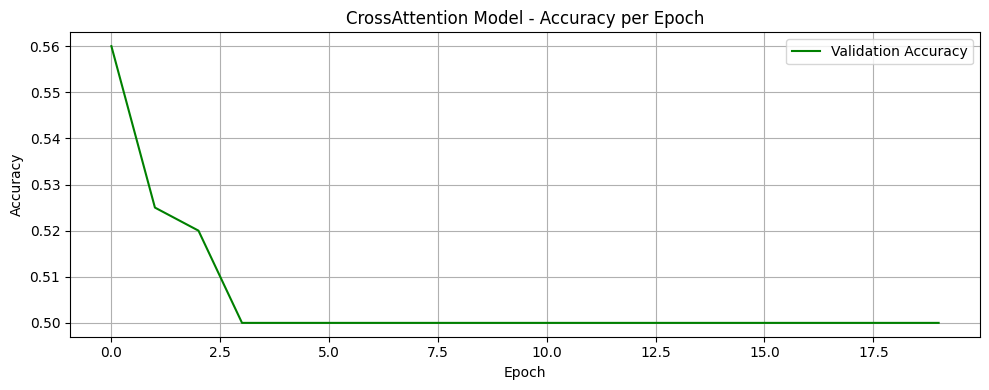

In [10]:
import json
import matplotlib.pyplot as plt

# JSON 불러오기
load_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_crossattention_both_model.json'

with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트 추출
train_losses = loss_history['train_loss']
val_losses = loss_history['val_loss']
val_accuracies = loss_history['val_accuracy']

# 손실 그래프
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linestyle='--')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CrossAttention Model - Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 정확도 그래프
plt.figure(figsize=(10, 4))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CrossAttention Model - Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### [11] 예측 수행

In [11]:
from tqdm import tqdm
import json
import torch

# 모델 로드
model = CrossAttentionBothEyeClassifier(dropout_p=0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_crossattention_both_model.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left_imgs, right_imgs, labels in tqdm(test_loader, desc="Predicting"):
        left_imgs = left_imgs.to(device)
        right_imgs = right_imgs.to(device)

        outputs = model(left_imgs, right_imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for true, pred, prob in zip(labels.cpu(), preds.cpu(), probs[:, 1].cpu()):
            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item())  # class 1 (고위험군) 확률
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_crossattention_both_model.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [01:32<00:00, 13.24s/it]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_crossattention_both_model.json


### [12] 평가

[CrossAttentionBothEyeClassifier Evaluation]
정확도 (Accuracy): 0.5800
AUC-ROC: 0.8636

분류 리포트:
              precision    recall  f1-score   support

      Normal       1.00      0.16      0.28        50
   Thickened       0.54      1.00      0.70        50

    accuracy                           0.58       100
   macro avg       0.77      0.58      0.49       100
weighted avg       0.77      0.58      0.49       100

Confusion Matrix:
[[ 8 42]
 [ 0 50]]


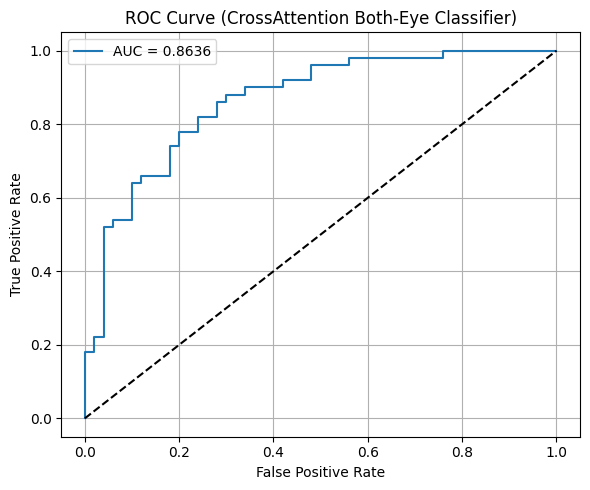

In [12]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_crossattention_both_model.json", "r") as f:
    results = json.load(f)

# 분류 관련 데이터 추출
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# === 분류 평가 === #
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

print("[CrossAttentionBothEyeClassifier Evaluation]")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# === ROC Curve === #
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (CrossAttention Both-Eye Classifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
